Code to process data for and plot Figure 2 from Siegfried\*, Venturelli\*, et al. (2023)

This notebook also estimates the mean and standard deviation lake sediment thickness

Email siegfried@mines.edu and venturelli@mines.edu with any questions

In [1]:
from pydicom import dcmread
import matplotlib.pyplot as plt
import seaborn as sns
import pygmt 
                 
import pandas as pd
import numpy as np
from glob import glob
import time
import random
import skimage.segmentation as seg
from scipy import optimize

# Initial load of CT dicom files

We have all the individual CT images stored in `data/01UW-C` as dicom files. Loop through them, load them, and then sort them by the slice location to make sure they are listed in our list (`slices`) of 2D numpy arrays (`ds`) correctly

In [2]:
# get the list of files for the core
files = glob('../data/cores/01UW-C/IM*')

# skip files with no SliceLocation information (should be a float)
slices = []
skipcount = 0
for f in files:
    ds = dcmread(f)
    if isinstance(ds.SliceLocation,float):
        slices.append(ds)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))
print("loaded: {}".format(len(slices)))
# re-sort to put the slices in the right order
slices = sorted(slices, key=lambda s: s.SliceLocation)

skipped, no SliceLocation: 0
loaded: 34


# Initial processing

Now that they are loaded, we need to build the 3D numpy array (`img3d`), then toss out the bits of the images that are just CT background

After we do that, we are left with our 3D numpy array `core` that forms the basis of everything we will do. The first thing will be to run a quick unsupervised classification to isolate lake sediments at the top of the column

In [4]:
# pixel dimensions, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d
    
# Subset to get rid of most of the background -- indices determined by hand
core = np.copy(img3d[70:1500,670:871,:])

# get the shape of the images and make vectors for x (columns), y (rows), and z (slices).
shp = core.shape
yvals = np.arange(0,shp[0])*ps[0]
xvals = np.arange(0,shp[1])*ps[1]-np.mean(np.arange(0,shp[1])*ps[1])
zvals = np.arange(0,shp[2])*ss-np.mean(np.arange(0,shp[2])*ss)

# go through and do a quick unsupervised classification of the core that
# we will use as a mask to only look at laminated lake sediments
core_mask = np.empty(core.shape)
for i in np.arange(0,shp[2]):
    thisslice = core[:,:,i]
    mskd = seg.slic(thisslice, n_segments=3, start_label=0, channel_axis=None)
    core_mask[:,:,i] = mskd

# load traced tops of undeformed core -- these are indices relative to 70 mm that were hand picked
coretops = pd.read_csv('../data/cores/core_tops.csv')

# only use indices from -2 cm to +2.5 cm in x (edges are deformed)
minx = -20 # in mm
maxx = 25 # in mm
ix = np.where(np.logical_and(xvals>=minx, xvals<=maxx))[0]
xvals_subset = xvals[ix]

# Processing to brightness values

Let's process to brightness values now. 

There are two cells to do this:

(1) Mask to only lake sediments. This NaN-pads the top of the region until it reaches the top of the lake sediments (which were hand traced horizons). This cell also plots each slice  with non-lake sediments transparent and lake sediments full opacity as a sanity check to make sure everything worked right

(2) With all the images appropriately masked, we concatonated all the traces into an individual pandas dataframe, then filter it to remove clasts (identified with a brightness threshold determined by looking at a histogram) and remove voids (identified as negative brightness values). We set the threshold to throw out a trace at 2% for each. We then plot all the traces side-by-side, the traces filtered for clasts, the traces filtered for voids, and the traces filtered for voids and clasts to make sure everything looks right.

In [5]:
# sample core vertical for pixel brightness values
# limit to certain slices and certain location in the core to avoid deformed bits

# need a consistent area of laminated lake seds to find the right mask value; arbitrarily determined
miny_laminated = 100 # in mm
maxy_laminated = 120 # in mm
iy_laminated = np.where(np.logical_and(yvals>=miny_laminated, yvals<=maxy_laminated))[0]


# only use incides from slices at -11.0 mm to 3.0 mm determined as the
# undeformed slices by eye. 
min_slice = -13 # in mm
max_slice = -5 # in mm
iz = np.where(np.logical_and(zvals>=min_slice, zvals<=max_slice))[0]

# grab depth indices that we will extract
miny = 70 # in mm
maxy = 170 # in mm
iy = np.where(np.logical_and(yvals>=miny, yvals<=maxy))[0]
yvals_subset = yvals[iy]

traces_out = np.empty((len(yvals_subset),len(xvals_subset)*len(iz)))

# extract each slice of undeformed laminated sediments
for cnt,i in enumerate(iz):
    thisslice = np.copy(core[:,:,i])
    seds_nomsk = np.copy(thisslice)
    thistop = coretops.iloc[:,[cnt]]

    # mask the core slice
    msk = core_mask[:,:,i]
    msk_val = np.round(msk[iy_laminated,:][:,ix].mean())
    thisslice[msk!=msk_val] = np.nan
    thisslice[thisslice<0] = np.nan
    
    # subset to the lake sediments
    seds = thisslice[iy,:][:,ix]
    seds_nomsk = seds_nomsk[iy,:][:,ix]
    
    # go through each vertical trace and fill nans to the core top
    for j in np.arange(0,len(seds[0,:])):
        seds[0:int(thistop.iloc[j]),j] = np.nan
    
    traces_out[:,cnt*len(xvals_subset):(cnt+1)*len(xvals_subset)] = seds


/var/folders/j3/_gy0_7wn1m141m6hvp62wkwm0000gn/T/ipykernel_39307/3913809080.py:42: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  seds[0:int(thistop.iloc[j]),j] = np.nan


In [6]:
thresh = 800 # brightness threshold for saying something is a clast
filt_limit = 0.02 # if a trace has more than this fraction of "bad" data, throw it out

# calculate number of values between top and bottom of lake sediments
shp = traces_out.shape
num_values=np.empty(shp[1])

# find the last NaN on top and the first NaN on bottom, then calculate the number of indices in-between
for i in np.arange(0,shp[1]):
    thistrace = traces_out[:,i]
    idx_start = np.argmin(np.isnan(thistrace))
    idx_end = len(thistrace)-np.argmin(np.isnan(np.flip(thistrace)))
    num_values[i] = idx_end - idx_start
    
# use our clast brightness threshold to filter
clasts=traces_out>thresh
no_clasts = np.sum(clasts,axis=0)/num_values < filt_limit

# we already replaced all negative brightness with nan, so now we just count them up
no_voids = np.sum(~np.isnan(traces_out), axis=0)/num_values > 1 - filt_limit


In [6]:
# Cell for saving all the traces, which is used in proc/!
# (uncomment this to do the saving)
"""
df_filtered = pd.DataFrame(traces_out[:,np.logical_and(no_clasts,no_voids)])
df_filtered = df_filtered.set_index(yvals_subset-yvals_subset[0])
df_filtered.to_csv('../data/cores/asm_input_data/core_traces_filtered.csv', header = False, na_rep='nan')
"""

"\ndf_filtered = pd.DataFrame(traces_out[:,np.logical_and(no_clasts,no_voids)])\ndf_filtered = df_filtered.set_index(yvals_subset-yvals_subset[0])\ndf_filtered.to_csv('../data/cores/asm_input_data/core_traces_filtered.csv', header = False, na_rep='nan')\n"

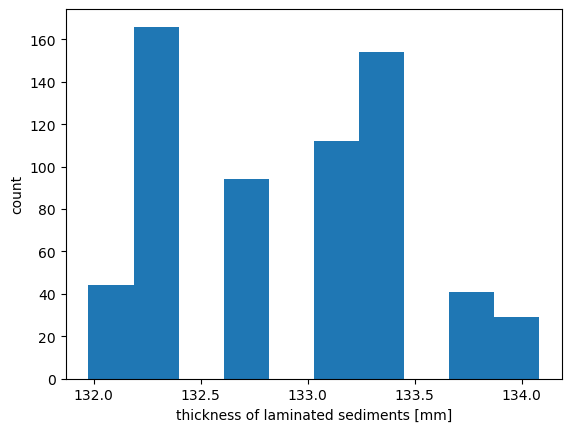

mean lake sediment thickness: 132.90011718750003 ± 0.5630225825440648


In [7]:
# sample core vertical for pixel brightness values
# limit to certain slices and certain location in the core to avoid deformed bits

# only use incides from slices at -11.0 mm to 3.0 mm determined as the
# undeformed slices by eye. 
min_slice = -13 # in mm
max_slice = -5 # in mm
iz = np.where(np.logical_and(zvals>=min_slice, zvals<=max_slice))[0]

# grab depth indices that we will extract
miny = 20 # in mm
maxy = 170 # in mm
iy = np.where(np.logical_and(yvals>=miny, yvals<=maxy))[0]
yvals_subset = yvals[iy]

traces_out = np.empty((len(yvals_subset),len(xvals_subset)*len(iz)))

# extract each slice of undeformed laminated sediments
for cnt,i in enumerate(iz):
    thisslice = np.copy(core[:,:,i])
    seds_nomsk = np.copy(thisslice)

    # mask the core slice
    msk = core_mask[:,:,i]
    msk_val = np.round(msk[iy_laminated,:][:,ix].mean())
    thisslice[msk!=msk_val] = np.nan
    thisslice[thisslice<0] = np.nan
    
    # subset to the lake sediments
    seds = thisslice[iy,:][:,ix]
    seds_nomsk = seds_nomsk[iy,:][:,ix]
    
    traces_out[:,cnt*len(xvals_subset):(cnt+1)*len(xvals_subset)] = seds

# calculate number of values between top of core and bottom of lake sediments
shp = traces_out.shape
num_values=np.empty(shp[1])
idx_start=np.empty(shp[1])
idx_end=np.empty(shp[1])

# find the last NaN on top and the first NaN on bottom, then calculate the number of indices in-between
for i in np.arange(0,shp[1]):
    thistrace = traces_out[:,i]
    idx_start[i] = np.argmin(np.isnan(thistrace))
    idx_end[i] = len(thistrace)-np.argmin(np.isnan(np.flip(thistrace)))
    num_values[i] = idx_end[i] - idx_start[i]
    
fig,ax = plt.subplots(1,1,facecolor='white')
plt.hist(num_values*ps[1])
plt.xlabel('thickness of laminated sediments [mm]')
plt.ylabel('count')
plt.show()
print('mean lake sediment thickness: ' + 
      str(np.mean(num_values*ps[1])) + 
      ' ± '  + str(np.std(num_values*ps[1])))

In [8]:
np.savetxt('../data/cores/spectral_analysis/thickness_distribution.txt', num_values*ps[1])

## Now let's plot Figure 2

<>:59: SyntaxWarning: invalid escape sequence '\i'
<>:60: SyntaxWarning: invalid escape sequence '\i'
<>:59: SyntaxWarning: invalid escape sequence '\i'
<>:60: SyntaxWarning: invalid escape sequence '\i'
/var/folders/j3/_gy0_7wn1m141m6hvp62wkwm0000gn/T/ipykernel_39307/2280086899.py:59: SyntaxWarning: invalid escape sequence '\i'
  ax1.set_xlabel('$\it{x}$ (mm)')
/var/folders/j3/_gy0_7wn1m141m6hvp62wkwm0000gn/T/ipykernel_39307/2280086899.py:60: SyntaxWarning: invalid escape sequence '\i'
  ax1.set_ylabel('$\it{z}$ (mm)')


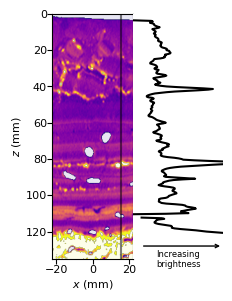

In [9]:
###### PLOT FIGURE 2 - LAMINATED SEDIMENTS WITH BRIGHTNESS TRACE

#### pre-process the laminated core image
thresh = 800 # brightness threshold for saying something is a clast
idx_top = 90
idx_bottom = 475
idx_left = 5

# only use indices from -2 cm to +2.5 cm in x (edges are deformed)
minx = -20 # in mm
maxx = 25 # in mm
ix = np.where(np.logical_and(xvals>=minx, xvals<=maxx))[0]
xvals_subset = xvals[ix]

# need a consistent area of laminated lake seds to find the right mask value; arbitrarily determined
miny_laminated = 100 # in mm
maxy_laminated = 120 # in mm
iy_laminated = np.where(np.logical_and(yvals>=miny_laminated, yvals<=maxy_laminated))[0]

#plot the slice at -5 mm
slice_val = -13
i = np.where(zvals==slice_val)[0]
msk = core_mask[:,:,i]
thisslice = np.copy(core[:,:,i])
msk_val = np.round(msk[iy_laminated,:][:,ix].mean())
thisslice[msk!=msk_val] = np.nan #mask non-laminated seds
thisslice[thisslice<0] = np.nan #filter voids
thisslice[thisslice>thresh] = np.nan #filter clasts

xwid = max(xvals_subset)-min(xvals_subset)
ywid = yvals[idx_bottom] - yvals[idx_top]
figwid = 1.05
fighgt = figwid * ywid/xwid
wspace=0
climits = [100,700]

i_trace=int(np.floor(ix.shape[0]/10)*9)
with plt.rc_context({"axes.labelsize": 8, 
                     "xtick.labelsize": 8, "ytick.labelsize": 8,
                     'xtick.major.pad': 1, 'ytick.major.pad': 0, 
                     'axes.labelpad': 2}):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(figwid*2.1+figwid*wspace,fighgt), facecolor='white', 
                                 gridspec_kw={'width_ratios': [1,1.1],'wspace':wspace})

#### plot panel A. - core image
    im2 = ax1.imshow(thisslice[idx_top:idx_bottom,ix], cmap='plasma', 
                     extent=[min(xvals_subset)-np.mean(xvals_subset), 
                             max(xvals_subset)-np.mean(xvals_subset), 
                             yvals[idx_bottom]-yvals[idx_top], 0],
                     aspect="auto")
    im1 = ax1.imshow(core[idx_top:idx_bottom,ix,i], cmap='plasma', 
                     extent=[min(xvals_subset)-np.mean(xvals_subset), 
                             max(xvals_subset)-np.mean(xvals_subset), 
                             yvals[idx_bottom]-yvals[idx_top], 0],
                     alpha=0.1, aspect = "auto")

    im1.set_clim(climits)
    im2.set_clim(climits)
    ax1.set_xlabel('$\it{x}$ (mm)')
    ax1.set_ylabel('$\it{z}$ (mm)')
    ax1.plot([xvals_subset[i_trace]-np.mean(xvals_subset),
              xvals_subset[i_trace]-np.mean(xvals_subset)],
             [0,yvals[idx_bottom] - yvals[idx_top]],'k',alpha=0.5)
    
    # plot panel (b)
    ax2.yaxis.set_visible(False)
    ax2.xaxis.set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    # plot example trace
    ax2.plot(thisslice[idx_top:idx_bottom,ix[i_trace]],
             yvals[idx_top:idx_bottom] - yvals[idx_top],'k')
    ax2.annotate("Increasing\nbrightness", size=6,
                 xy=(400, 130), xytext=(400, 130),
                 ha="center", va="top")
    ax2.annotate("", size=6,
                 xy=(700, 128), xytext=(150, 128),
                 arrowprops=dict(arrowstyle="->"))
    ax2.invert_yaxis()
    ax2.set_ylim(yvals[idx_bottom]-yvals[idx_top], 0)
    ax2.set_xlim(climits)
    


    plt.savefig('siegvent2023-fig2.png', 
                bbox_inches='tight', transparent = False, dpi = 600)
    plt.show()
    

########
